In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt


In [2]:
batch_size   = 128
latent_dim   = 16
num_epochs   = 50
learning_rate = 1e-3
data_root    = "./data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
transform = transforms.ToTensor()


train_dataset = datasets.MNIST(root=data_root,
                               train=True,
                               transform=transform,
                               download=True)
test_dataset  = datasets.MNIST(root=data_root,
                               train=False,
                               transform=transform,
                               download=True)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)
test_loader  = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2,
                          pin_memory=True)


Epoch [01/50]  Loss: 45.4496  Recon: 35.5101  KL: 9.9395
Epoch [02/50]  Loss: 33.4809  Recon: 21.3791  KL: 12.1018
Epoch [03/50]  Loss: 32.0178  Recon: 19.5860  KL: 12.4318
Epoch [04/50]  Loss: 31.3407  Recon: 18.8171  KL: 12.5235
Epoch [05/50]  Loss: 30.9109  Recon: 18.3277  KL: 12.5832
Epoch [06/50]  Loss: 30.6050  Recon: 17.9568  KL: 12.6483
Epoch [07/50]  Loss: 30.3282  Recon: 17.6861  KL: 12.6420
Epoch [08/50]  Loss: 30.1067  Recon: 17.4349  KL: 12.6719
Epoch [09/50]  Loss: 29.9592  Recon: 17.2340  KL: 12.7252
Epoch [10/50]  Loss: 29.7823  Recon: 17.0482  KL: 12.7341
Epoch [11/50]  Loss: 29.6245  Recon: 16.8934  KL: 12.7311
Epoch [12/50]  Loss: 29.5073  Recon: 16.7701  KL: 12.7372
Epoch [13/50]  Loss: 29.4009  Recon: 16.6625  KL: 12.7384
Epoch [14/50]  Loss: 29.2982  Recon: 16.5411  KL: 12.7571
Epoch [15/50]  Loss: 29.1871  Recon: 16.4528  KL: 12.7342
Epoch [16/50]  Loss: 29.1204  Recon: 16.3718  KL: 12.7486
Epoch [17/50]  Loss: 29.0388  Recon: 16.2908  KL: 12.7479
Epoch [18/50]  

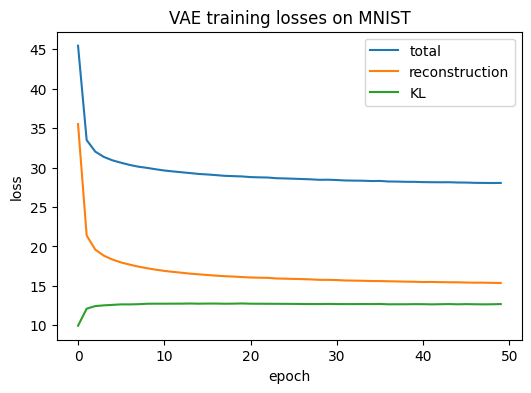

In [4]:
# Conv VAE model
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: 1x28x28 -> 64x7x7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28 -> 14
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 14 -> 7
            nn.ReLU(True),
        )
        self.enc_out_dim = 64 * 7 * 7

        self.fc_mu     = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)

        # Decoder: latent z -> feature map -> 1x28x28
        self.fc_dec = nn.Linear(latent_dim, self.enc_out_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 7 -> 14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 14 -> 28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(x.size(0), -1)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 64, 7, 7)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z          = self.reparameterize(mu, logvar)
        x_recon    = self.decode(z)
        return x_recon, mu, logvar


model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def vae_loss(recon_x, x, mu, logvar):
    batch_size = x.size(0)
    recon_loss = F.mse_loss(recon_x, x, reduction="sum") / batch_size
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
    loss = recon_loss + kl
    return loss, recon_loss, kl


train_losses = []
recon_losses = []
kl_losses    = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    running_rec  = 0.0
    running_kl   = 0.0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss, rec, kl = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_rec  += rec.item()
        running_kl   += kl.item()

    avg_loss = running_loss / len(train_loader)
    avg_rec  = running_rec  / len(train_loader)
    avg_kl   = running_kl   / len(train_loader)

    train_losses.append(avg_loss)
    recon_losses.append(avg_rec)
    kl_losses.append(avg_kl)

    print(f"Epoch [{epoch:02d}/{num_epochs}]  "
          f"Loss: {avg_loss:.4f}  Recon: {avg_rec:.4f}  KL: {avg_kl:.4f}")

print("Training finished.")


plt.figure(figsize=(6,4))
plt.plot(train_losses, label="total")
plt.plot(recon_losses, label="reconstruction")
plt.plot(kl_losses, label="KL")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("VAE training losses on MNIST")
plt.show()


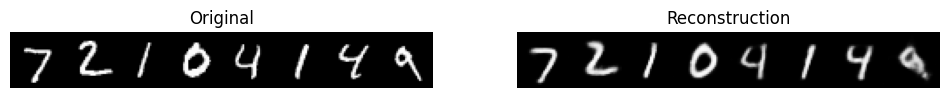

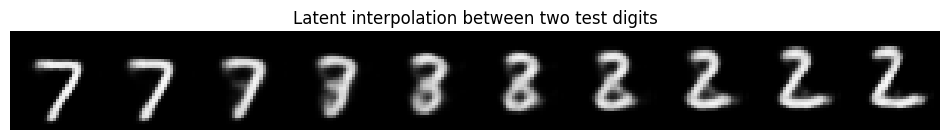

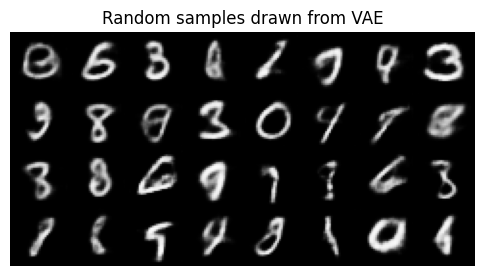

In [7]:
def show_reconstructions(model, data_loader, num_images=8):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)
        recon_x, _, _ = model(x)

    x      = x[:num_images].cpu()
    recon  = recon_x[:num_images].cpu()
    grid_input = vutils.make_grid(x, nrow=num_images, padding=2)
    grid_recon = vutils.make_grid(recon, nrow=num_images, padding=2)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(grid_input.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(grid_recon.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Reconstruction")

    plt.show()

show_reconstructions(model, test_loader, num_images=8)

def show_latent_interpolation(model, data_loader, num_steps=8):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)

        x1 = x[0:1]
        x2 = x[1:2]

        mu1, logvar1 = model.encode(x1)
        mu2, logvar2 = model.encode(x2)

        z1 = mu1
        z2 = mu2

        alphas = torch.linspace(0.0, 1.0, num_steps, device=device).view(-1,1)
        zs = (1 - alphas) * z1 + alphas * z2  # linear interp

        imgs = model.decode(zs).cpu()

    grid = vutils.make_grid(imgs, nrow=num_steps, padding=2)
    plt.figure(figsize=(12,2))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Latent interpolation between two test digits")
    plt.show()

show_latent_interpolation(model, test_loader, num_steps=10)

def show_random_samples(model, num_samples=32):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        imgs = model.decode(z).cpu()

    grid = vutils.make_grid(imgs, nrow=8, padding=2)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Random samples drawn from VAE")
    plt.show()

show_random_samples(model, num_samples=32)
